replaced main.py with a tutorial notebook which should always be kept up to date with the package to show how to work with it

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import box

from TO import Topology, run_experiment
from TO.models import BinaryElasticMembraneModel
from TO.parameterizations import Capsules
from TO.parameterizations.mmc import MMCEndpointsConfig, MMCAngularConfig, MMCCenterpointsConfig
from TO.utils import get_fitness_values, get_best_config

from experiments.utils import set_plt_template
set_plt_template()

In [2]:
topology = Topology(
    continuous=True, 
    domain=box(0, 0, 100, 50), 
    density=0.2
)
parameterization = Capsules(
    topology,
    representation=MMCCenterpointsConfig,
    symmetry_x=False, 
    symmetry_y=True, 
    n_components_x=1, 
    n_components_y=2, 
    n_samples=100,
)
model = BinaryElasticMembraneModel(
    topology, 
    thickness=1, 
    E11=25, 
    E22=1, 
    G12=0.5, 
    nu12=0.25, 
    Emin=1e-9
)

In [3]:
from shutil import rmtree
import os

if os.path.exists('results/tutorial/') : rmtree('results/tutorial/')

In [4]:
run_experiment(
    topology, parameterization, model,
    sigma0=0.25, budget=500, seed=0,
    name='tutorial'
)

(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 5 (seed=652522, Tue Apr  1 13:06:20 2025)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 5.020806403114626e+04 1.0e+00 2.54e-01  2e-01  3e-01 0:00.1
    2     16 3.762116660936760e+04 1.4e+00 2.81e-01  3e-01  3e-01 0:00.1
    3     24 1.825025896525551e+00 1.7e+00 3.75e-01  3e-01  3e-01 0:00.1
   52    416 8.345466846383236e-02 1.7e+01 2.57e-02  3e-03  2e-02 0:03.2
   66    528 8.345466846383236e-02 2.2e+01 1.81e-02  1e-03  1e-02 0:04.2
termination on tolflatfitness=1 (Tue Apr  1 13:06:24 2025)
final/bestever f-value = 8.345467e-02 8.345467e-02 after 529/341 evaluations
incumbent solution: [0.9718502527556545, 0.48344167803869276, 0.024941080415505187, 0.00904171953009652, 0.13963659502176307]
std deviation: [0.006766868744979112, 0.004106926518199989, 0.0075007125507877154, 0.012392557347003457, 0.001399995564789182]


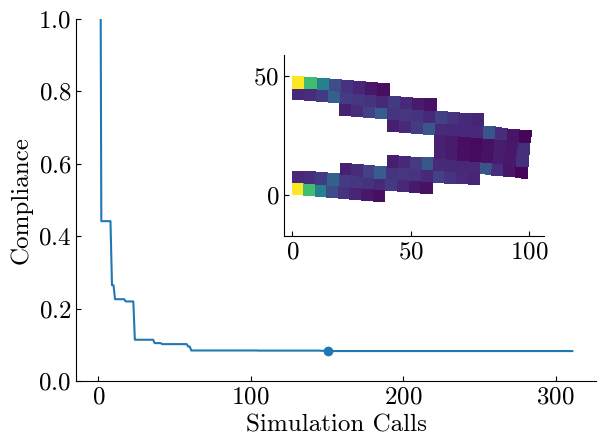

In [5]:
# getting the fitness values of the simulation calls
f = get_fitness_values('tutorial', 0)
fmin = np.minimum.accumulate(f)

x_best = get_best_config('tutorial', 0)
parameterization.update_topology(topology, x_best)
# running the simulation one last time on best found config
model.update(topology) 
C = model.compute_element_compliance()

fig, ax = plt.subplots()
ins = ax.inset_axes([0.4,0.4,0.5,0.5])

ax.plot(fmin.argmin()+1, fmin.min(), 'C0o'); ax.plot(np.arange(fmin.size)+1, fmin); model.plot(C, fac=10, ax=ins); ins.axis('equal')
ax.set_ylim(0, 1); ax.set_xlabel('Simulation Calls'); ax.set_ylabel('Compliance'); fig.tight_layout()